# Import packages

In [535]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [536]:
import torch 
from torch import nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset

# Configurations

In [537]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0, # Learning rate
    "gamma": 0.7, # Learning rate step gamma
    "dry_run": False,
    "seed": 1,
    "log_interval": 10,
    "data_dir": "./data",
    "subset_size": 500
}

# Import and Preprocessing Dataset

In [538]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = MNIST(root = './data', train = True, download = True, transform = transform)
test_set = MNIST(root = './data', train = False, download = False, transform = transform)

# Nerual Network Definition

In [539]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(), 
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.fc_layers(self.conv_layers(x))

# Training and Testing

In [540]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args['dry_run']:
                break

In [541]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# KPI1: Use 500 training samples.

## Randomly select 500 samples

In [542]:
def get_balanced_subset_indices(targets, num_classes, num_per_class):
    indices = []
    for i in range(num_classes):
        class_indices = (targets == i).nonzero(as_tuple=True)[0]
        random_indices = np.random.choice(class_indices, num_per_class, replace=False)
        indices.extend(random_indices)
    return indices

In [543]:
num_classes = 10
num_per_class = 50

train_indices = get_balanced_subset_indices(train_set.targets, num_classes, num_per_class)

train_subset = Subset(train_set, train_indices)

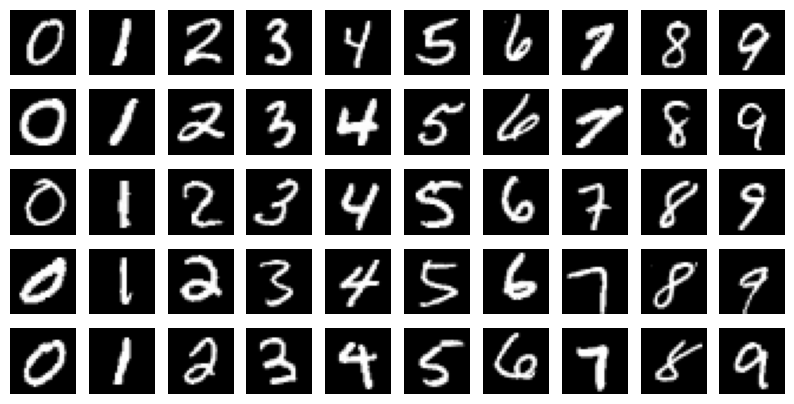

In [544]:
rows = 5
fig, axes = plt.subplots(rows, 10, figsize=(10 ,rows))

for i in range (10):
    ds  = [x for x, y in train_subset if y == i]
    for j in range(rows):
        ax = axes[j,i]
        ax.imshow(ds[j][0].numpy().reshape(28,28), cmap='gray')
        ax.axis('off')
        
plt.show() 

In [545]:
train_kwargs = {'batch_size': config['batch_size']}
test_kwargs = {'batch_size': config['test_batch_size']}
if torch.cuda.is_available():
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(train_subset, **train_kwargs)
test_loader = DataLoader(test_set, **test_kwargs)

In [546]:
def train_and_test_model(train_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=config['lr'])
    
    scheduler = StepLR(optimizer, step_size=1, gamma=config['gamma'])
    for epoch in range(1, config['epochs'] + 1):
        train(config, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

In [547]:
train_and_test_model(train_loader)

Train Epoch: 1 [0/500 (0%)]	Loss: 2.305538

Test set: Average loss: 2.2946, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/500 (0%)]	Loss: 2.264463

Test set: Average loss: 2.2833, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/500 (0%)]	Loss: 2.245931

Test set: Average loss: 2.2567, Accuracy: 1277/10000 (13%)

Train Epoch: 4 [0/500 (0%)]	Loss: 2.208711

Test set: Average loss: 2.2008, Accuracy: 2241/10000 (22%)

Train Epoch: 5 [0/500 (0%)]	Loss: 2.122112

Test set: Average loss: 2.1134, Accuracy: 3637/10000 (36%)

Train Epoch: 6 [0/500 (0%)]	Loss: 1.987064

Test set: Average loss: 2.0068, Accuracy: 5258/10000 (53%)

Train Epoch: 7 [0/500 (0%)]	Loss: 1.788807

Test set: Average loss: 1.8861, Accuracy: 6246/10000 (62%)

Train Epoch: 8 [0/500 (0%)]	Loss: 1.561010

Test set: Average loss: 1.7685, Accuracy: 6775/10000 (68%)

Train Epoch: 9 [0/500 (0%)]	Loss: 1.398967

Test set: Average loss: 1.6745, Accuracy: 7048/10000 (70%)

Train Epoch: 10 [0/500 (0%)]	Loss: 1.196571

Test set: Average l

### Data Augmentation

In [548]:
from torch.utils.data import ConcatDataset

augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 对子集应用数据增强
concat_dataset = train_subset
train_subset.dataset.transform = augment_transform
augmented_train_loader = DataLoader(concat_dataset, batch_size=64, shuffle=True)

for i in range(5):
    concat_dataset = ConcatDataset([concat_dataset, train_subset])
    augmented_train_loader = DataLoader(concat_dataset, batch_size=64, shuffle=True)
    
train_and_test_model(augmented_train_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.313491
Train Epoch: 1 [640/3000 (21%)]	Loss: 1.496737
Train Epoch: 1 [1280/3000 (43%)]	Loss: 0.803240
Train Epoch: 1 [1920/3000 (64%)]	Loss: 0.555413
Train Epoch: 1 [2560/3000 (85%)]	Loss: 0.585762

Test set: Average loss: 0.2926, Accuracy: 9048/10000 (90%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.369474
Train Epoch: 2 [640/3000 (21%)]	Loss: 0.189353
Train Epoch: 2 [1280/3000 (43%)]	Loss: 0.228014
Train Epoch: 2 [1920/3000 (64%)]	Loss: 0.324385
Train Epoch: 2 [2560/3000 (85%)]	Loss: 0.223593

Test set: Average loss: 0.2020, Accuracy: 9381/10000 (94%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.230474
Train Epoch: 3 [640/3000 (21%)]	Loss: 0.427702
Train Epoch: 3 [1280/3000 (43%)]	Loss: 0.220835
Train Epoch: 3 [1920/3000 (64%)]	Loss: 0.148466
Train Epoch: 3 [2560/3000 (85%)]	Loss: 0.104602

Test set: Average loss: 0.1959, Accuracy: 9429/10000 (94%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.079907
Train Epoch: 4 [640/3000 (21%)]	Loss: 0.255843
Train Epoch: 4 [1280/